In [1]:
from __future__ import print_function
import struct
import numpy as np
import math
import sys
import ROOT
import array
import matplotlib.pyplot as plt

import matplotlib.pylab as pltt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.patches import Ellipse,Arrow
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

import matplotlib
font = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 30}
matplotlib.rc('font', **font)
import matplotlib.font_manager as font_manager


Welcome to JupyROOT 6.24/06


### Commond abbreviation and conversion equations:

| nuc | Nuclear mass (u) | Mass excess (keV) | Binding energy (/A) keV | Atomic mass (u) |
|:---|:-----------------:|:-----------------------:|:---------------:|:---------------:|
|  | $\mathrm{M_{n}(A,Z)}$ | $\mathrm{ME_{n}(A,Z)}$ | $\mathrm{B_{n}(A,Z)}$ | $\mathrm{M_{a}(A,Z)}$ | 
| n  | x | 8071.31806      | 0 | 1.00866491590 |
| 13C6  | x | 3125.00933   | 7469.8495 | 13.00335483534 |
| 16O8  | x | -4737.00217   | 7976.2072 | 15.99491461926 |

13 003354.83534

- 1 a.m.u unit (physics.nist.gov CODATA and AME2022):

$$
u_{1} = 931494.10242 \pm 0.00028 \;keV
$$


- Atomic unit to keV conversion:

$$
\mathrm{M_{n}(A,Z)} (in\;keV) = u_{1} \times  \mathrm{M_{n}(A,Z)} (in\;u)
$$

- Mass excess from atomic mass $M_{a}(A,Z)$ (in u):
$$
ME_{a}(A,Z) (in\;keV) = u_{1} \times (M_{a}(A,Z) (in\;u) - A)
$$

- Nuclear mass from atomic mass $M_{a}(A,Z)$ (in u):

$$
M_{n}(A,Z) = M_{a}(A,Z) - Z \times m_{e} + B_{e}(Z)
$$

with
$$
B_{e}(Z) = (14.4381 Z^{2.39} + 1.55468 \times 10^{-6} Z^{5.35})\times 10^{-3} / u_{1}\;u
$$

and
$$
m_{e} = (510.99895000 \pm 0.000000015) / u_{1} \;u
$$

- Binding energy per nucleon from atomic mass  \$M_{a}(A,Z)$ (in u):

$$
B(A,Z)/A (in\;keV) = 1/A[Z \times ME_{a}(^{1}H) + N \times ME_{a}(neutron) - ME_{a}(A,Z)]
$$

with
$$
ME(^{1}H) = 1.007825031898 \pm 0.000000000473 \;u
$$

and

$$
ME(neutron) = 1.008664915904 \pm 0.000000000014 \;u
$$



## For FRDM+QRPA 2012

[Möller, P., Sierk, A. J., Ichikawa, T., & Sagawa, H. (2016). Nuclear ground-state masses and deformations: FRDM (2012). Atomic Data and Nuclear Data Tables, 109, 1-204.](https://doi.org/10.1016/j.adt.2015.10.002)


$$
M_{n}(A,Z) = M_{a}(A,Z) - Z \times m_{e} + a_{el} \times Z^{2.39}
$$

$$
a_{el}= 0.01433\;keV
$$


$$
m_{e}= 510.99906\;keV
$$

$$
E_{bind}(Z,N) = ZM_{n}(proton) + NM_{n}(neutron) - M_{n}(Z,N) = Z(ME_{H}+1 - m_{e}+a_{el})+N(ME_{H}+1)-(ME_{n}(Z,N)+Z+N)
$$

$$
1\;u = 931501.4\;keV
$$

$$
ME_{H} = 7289.034\;keV = 7289.034/931501.4\;u
$$


$$
ME_{n} = 8071.431\;keV = 8071.431/931501.4\;u
$$

- Example of the FRDM prediction:

$$
M_{th}(^{16}O) = -5.15\;MeV 
$$

$$
E_{bind (th)}(^{16}O) = 128.03\;MeV 
$$

In [2]:
u1 = 931494.10242
def amass_to_nmass_keV(amass,Z):
    u1 = 931494.10242
    meu = 0.000548579909065
    meKeV = 510.99895000
    Be = (14.4381*(Z**2.39)+1.55468e-6*(Z**5.35))*1e-3
    nmass = amass*u1-Z*meKeV+Be*Z
    return nmass

def amass_to_mass_excess_keV(amass,A):
    u1 = 931494.10242
    return (amass - A)*u1

def amass_to_binding_ene_per_A_keV_way1(amass,Z,A):
    u1 = 931494.10242
    neumass = 1.008664915904
    pmass =   1.007276466588
    return (neumass*(A-Z) + pmass*Z - amass_to_nmass_keV(amass,Z)/u1)*u1/A

def amass_to_binding_ene_per_A_keV(amass,Z,A):
    u1 = 931494.10242
    neumass = 1.008664915904
    h1mass = 1.007825031898
    return (neumass*(A-Z) + h1mass*Z - amass)*u1/A

def FRDM_massecess_keV_to_binding_ene_keV(massexcess,Z,A):
    u1 = 931501.4
    me_H = 7.289034e3
    me_n = 8.071431e3
    melectron = 510.99906
    ael = 1.433e-2
    return ((me_n/u1+1)*(A-Z)*u1 + (me_H/u1+1-melectron/u1+ael/u1)*Z*u1 - (massexcess+A*u1 - Z*melectron+ael*Z**2.39) )


def mass_excess_keV_to_amass(mass_excess,A):
    u1 = 931494.10242
    return mass_excess/u1 + A


In [3]:
print(amass_to_mass_excess_keV(1.00866491590,1))

8071.318058815352


In [4]:
print(amass_to_mass_excess_keV(13.00335483534,13))

3125.009333799912


In [5]:
print(mass_excess_keV_to_amass(3125.009333799912,13))

13.00335483534


In [6]:
print(amass_to_binding_ene_per_A_keV(13.00335483534,6,13))

7469.849499184584


In [7]:
print(amass_to_mass_excess_keV(15.99491461926,16))

-4737.002167870856


In [8]:
print(amass_to_binding_ene_per_A_keV(15.99491461926,8,16))

7976.207198880236


In [9]:
print(FRDM_massecess_keV_to_binding_ene_keV(-5150,8,16))

128031.77101272531


### AME mass table 2020

In [10]:
ame = np.load("ame/all_ame20.npy",allow_pickle='TRUE')

In [11]:
for idx,i in enumerate(ame):
    if (i["A"]==90 and i["Z"]==38):
        mass_amu = i["A2"]+i["AM"]*1e-6
        dmass_amu = i["DAM"]*1e-6
        print(mass_amu,dmass_amu,amass_to_mass_excess_keV(i["A2"]+i["AM"]*1e-6,i["A"]),dmass_amu*u1,i["M"],i["DM"])

89.90772787 1.555e-06 -85950.9449127295 1.4484733292631 -85950.945 1.449


# TOF to mass conversion

- Observe TOF as a function of masses:

$$
t_{obs} = (a+b\cdot l) (m/q)^{1/2} +t_{0}
$$

where: $a$ and $b$ are constants related to non-reflection and flight path in MRTOF, $l$ is the *number of laps*,  **$m$ is the ionic mass** and $t_{0}$ is the TOF offset.

## Double referencing:

- Assuming we have two reference ion species (1,2) and one measured ion species:

(1):
$$
t_{1} = (a+b\cdot l) (m_{1}/q_{1})^{1/2} +t_{0}
$$

(2):
$$
t_{2} = (a+b\cdot l) (m_{2}/q_{2})^{1/2} +t_{0}
$$

(3):
$$
t = (a+b\cdot l) (m/q)^{1/2} +t_{0}
$$

- $2 \times (3) - (1) - (2)$  gives (4):

$$
2t-t_{1}-t_{2} = (a+b\cdot l)[2(m/q)^{1/2}-(m_{1}/q_{1})^{1/2}-(m_{2}/q_{2})^{1/2}]
$$

- $(1) - (2)$  gives (5):

$$
t_{1}-t_{2} = (a+b\cdot l)[(m_{1}/q_{1})^{1/2}-(m_{2}/q_{2})^{1/2}]
$$

- Or (6):

$$
(a+b\cdot l) = (t_{1}-t_{2}) / [(m_{1}/q_{1})^{1/2}-(m_{2}/q_{2})^{1/2}]
$$

- Combine (4) and (6) gives (7):


$$
\frac{2t-t_{1}-t_{2}}{(t_{1}-t_{2})} =  \frac{2(m/q)^{1/2}-(m_{1}/q_{1})^{1/2}-(m_{2}/q_{2})^{1/2}}{(m_{1}/q_{1})^{1/2}-(m_{2}/q_{2})^{1/2}}
$$

- Or (8): 

$$
C_{TOF} = \frac{2t-t_{1}-t_{2}}{2(t_{1}-t_{2})} =  \frac{(m/q)^{1/2}-[(m_{1}/q_{1})^{1/2}+(m_{2}/q_{2})^{1/2}]/2}{(m_{1}/q_{1})^{1/2}-(m_{2}/q_{2})^{1/2}}
$$



- Then (9):

$$
 (m/q)^{1/2} = C_{TOF}[(m_{1}/q_{1})^{1/2}-(m_{2}/q_{2})^{1/2}]+[(m_{1}/q_{1})^{1/2}+(m_{2}/q_{2})^{1/2}]/2
$$


## Single referencing:

- Assuming we have one reference ion species (ref) and one measured ion species:

(10):
$$
t_{ref} - t_{0} = (a+b\cdot l) (m_{ref}/q_{ref})^{1/2}
$$

(11):
$$
t - t_{0} = (a+b\cdot l) (m/q)^{1/2}
$$

- $(11)/(10)$ gives (12):
$$
\frac{t - t_{0}}{t_{ref} - t_{0}} = \frac{(m/q)^{1/2}}{(m_{ref}/q_{ref})^{1/2}}
$$

- Or (13):
$$
(m/q) = \left (\frac{t - t_{0}}{t_{ref} - t_{0}} \right )^{2} (m_{ref}/q_{ref})
$$



## Summary for a simplied scenario: Asssuming reference ions and measured ions have same charge states

- ### Single referencing:
$$
m = \left (\frac{t - t_{0}}{t_{ref} - t_{0}} \right )^{2} m_{ref}
$$

- ### Double referencing:
$$
m = \left ( C_{TOF}(m_{1}^{1/2}-m_{2}^{1/2})+(m_{1}^{1/2}+m_{2}^{1/2})/2 \right )^{2}
$$
where
$$
C_{TOF} = \frac{2t-t_{1}-t_{2}}{2(t_{1}-t_{2})}
$$

- Note that **$m$ is the ionic mass** for reference and measured ions. We need to derive it from the atomic mass having electrons (how about binding energy of electron?)

$$
M = m + q \times m_{e}
$$

$$
m_{ref} = M_{ref} - q \times m_{e}
$$

$$
m_{1} = M_{1}  -q \times m_{e}
$$

$$
m_{2} = M_{2} - q \times m_{e}
$$

Where: 

- $M_{ref}$, $M_{1}$ and $M_{2}$ is the atomic mass of the reference ion species, taken from latest AME database (AME2020) in a.m.u

- $m_{e}$ is the electron rest mass, taken from latest AME database (AME2020) in a.m.u as:
$$
m_{e} = 548579.909065 \times 10^{-9} \pm 0.000016 \times 10^{-9} \;u
$$

- Or alternatively:
$$
m_{e} = (510.99895000 \pm 0.000000015) / u_{1} \;u
$$

$$
u_{1} = 931494.10242 \pm 0.00028 \;keV
$$

In [12]:
### Write to csv file for C++ codes
f = open("mass_table_ame20.csv","w")
line = "Nuc,A,Z,N,mass,dmass,mass excess, dmass excess\n"
f.write(line)
for idx,i in enumerate(ame):
    mass_amu = i["A2"]+i["AM"]*1e-6
    dmass_amu = i["DAM"]*1e-6
    line = "%s,%i,%i,%i,%g,%g,%g,%g\n" % (i["EL"]+str(i["A"]),i["A"],i["Z"],i["N"],mass_amu,dmass_amu,i["M"],i["DM"])
    f.write(line)
f.close()

In [13]:
%%cpp
#include <fstream>
#include <vector>
#include <string>
#include <stdlib.h>
using namespace std;

typedef struct amedatum_t
{
    string Nuc;
    Int_t A;
    Int_t Z;
    Int_t N;
    Double_t mass;
    Double_t dmass;
    Double_t ME;
    Double_t dME;
}amedatum_t;

In [14]:
%%cpp
void getcsv(char* infile, vector<vector<string>>& content)
{
    vector<string> row;
    string line, word;

    fstream file (infile, ios::in);
    if(file.is_open())
    {
        while(getline(file, line))
        {
            row.clear();

            stringstream str(line);

            while(getline(str, word, ','))
                row.push_back(word);
            content.push_back(row);
        }
    }
    else
        cout<<"Could not open the file\n";
}

In [15]:
%%cpp
void getamedata(char* infile,vector<amedatum_t*>& amedata)
{
    vector<vector<string>> content;
    getcsv(infile,content);
    for(int i=0;i<content.size();i++)//row
    {
        if (i>0){
            amedatum_t* amedatum = new amedatum_t;
            amedatum->Nuc = content[i][0];
            amedatum->A = atoi(content[i][1].c_str());
            amedatum->Z = atoi(content[i][2].c_str());
            amedatum->N = atoi(content[i][3].c_str());
            amedatum->mass = atof(content[i][4].c_str());
            amedatum->dmass = atof(content[i][5].c_str());
            amedatum->ME = atof(content[i][6].c_str());
            amedatum->dME = atof(content[i][7].c_str());
            amedata.push_back(amedatum);
        }
    }
}

In [16]:
%%cpp
//get tabulated ame data
vector<amedatum_t*> amedata;
getamedata((char*)"mass_table_ame20.csv",amedata);

In [17]:
%%cpp
cout<<amedata[10]->Nuc<<endl;

He5


## Get fit results and calculate Mass

- Unbinned fitting code: [https://github.com/vihophong/heavy/tree/main/fit/unbinfitv0](https://github.com/vihophong/heavy/tree/main/fit/unbinfitv0)

In [18]:
%%cpp
TFile* f = TFile::Open("fit/unbinfitv0/fitresult_ddaq.csv.root");
TCanvas* c1_result = (TCanvas*) f->Get("c1");
TCanvas* c2_result = (TCanvas*) f->Get("c2");


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



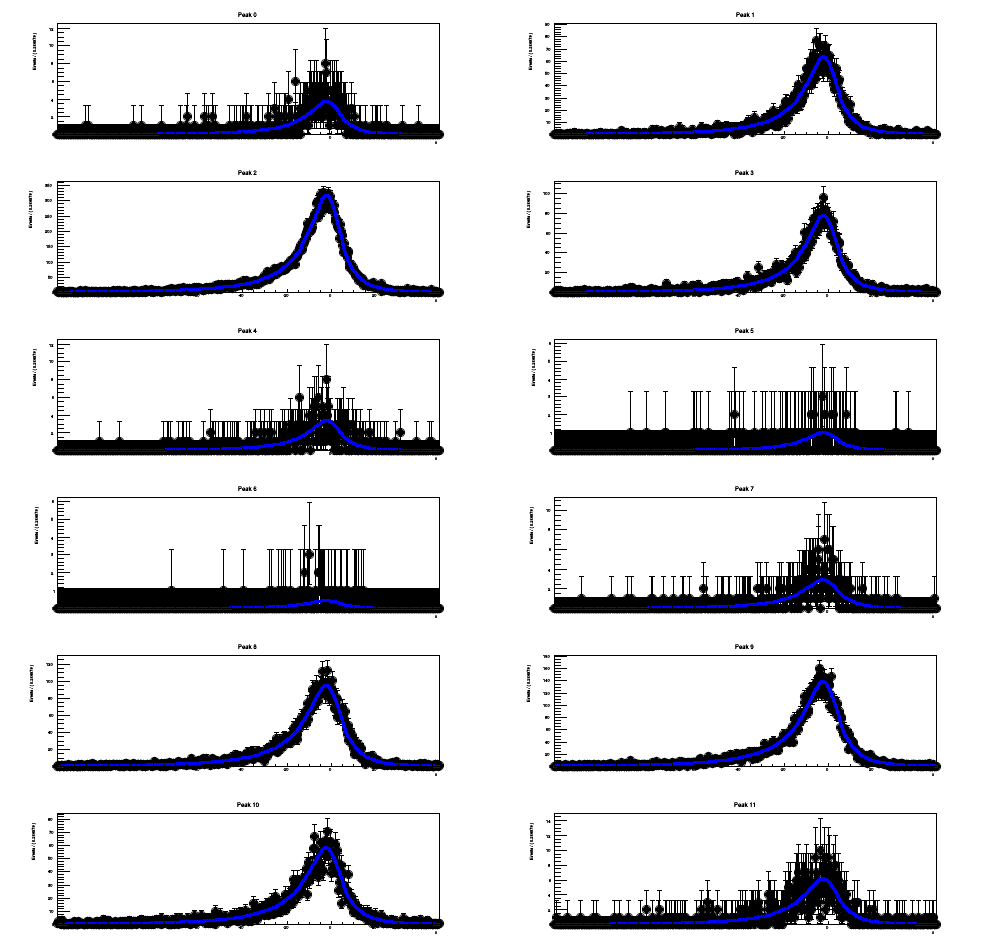

In [19]:
%%cpp
c1_result->Draw();

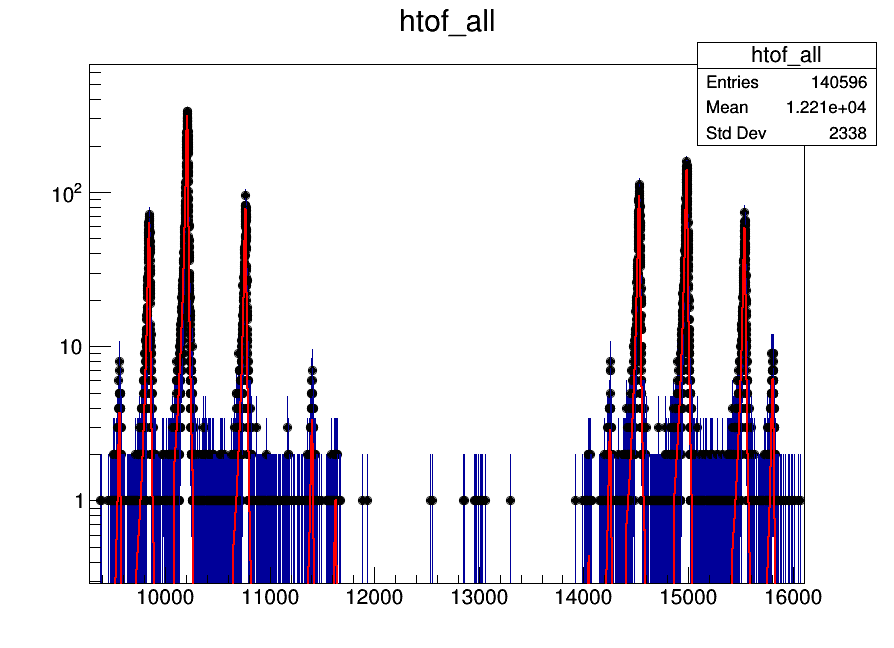

In [20]:
%%cpp
c2_result->Draw();

### Plotting tof vs mass and get t0

In [21]:
%%cpp
vector<vector<string>> content;
getcsv((char*)"fit/unbinfitv0/fitresult_ddaq.csv",content);
string peak_name[500];
Double_t peakpos[500];
Double_t peakpos_error[500];
Int_t npeaks = 0;
for(int i=0;i<content.size();i++)//row
{
    if (i>1){
        if (content[i].size()==0){
            break;
        }
        peak_name[npeaks] = content[i][1];
        peakpos[npeaks] = atof(content[i][2].c_str());
        peakpos_error[npeaks] = atof(content[i][3].c_str());
        npeaks++;
    }
}

Double_t mass[500];
Double_t dmass[500];

vector<Double_t> x;
vector<Double_t> dx;
vector<Double_t> y;
vector<Double_t> dy;
vector<string> pname;

Double_t me = 548579.909065e-9;
Double_t amutokeV = 931494.10242;
Double_t chargestate = 2;
//for mass 105
for (Int_t i=0;i<5;i++){
    mass[i] = -9999;
    dmass[i] = -9999;
    for (Int_t j=0;j<amedata.size();j++){
        if (peak_name[i]==amedata[j]->Nuc){
            mass[i] = amedata[j]->mass - chargestate* me;
            dmass[i] = amedata[j]->dmass;
            
            cout<<peak_name[i]<<"\t"<<amedata[j]->mass
                <<"\t"<<dmass[i]
                <<"\t"<<peakpos[i]
                <<"\t"<<peakpos_error[i]
                <<"\t"<<sqrt(mass[i]/2)
                <<"\t"<<sqrt(mass[i]/2)*0.5*dmass[i]/mass[i]<<endl;
            x.push_back(sqrt(mass[i]/chargestate));
            dx.push_back(sqrt(mass[i]/chargestate)*0.5*dmass[i]/mass[i]);
            y.push_back(peakpos[i]);
            dy.push_back(peakpos_error[i]);
            pname.push_back(peak_name[i]);
        }
    }
}

// TGraphErrors * grErr =new TGraphErrors(x.size(),&x[0],&y[0],&dx[0],&dy[0]);
// gStyle->SetOptFit(1111111);
// gStyle->SetStatX(0.5);       
// gStyle->SetStatY(0.85);               
// grErr->SetName("gr");
// grErr->SetTitle("Tof vs Mass");
// grErr->SetMarkerStyle(20);
// grErr->Fit("pol1");
// TCanvas * c3 =new TCanvas("c3","c3",900,700);
// c3->cd();
// grErr->Draw("AP");
// cout<<std::setprecision(16)<<grErr->GetFunction("pol1")->GetParameter(0)<<"\t"
//     <<grErr->GetFunction("pol1")->GetParError(0)<<"\t"
//     <<grErr->GetFunction("pol1")->GetParameter(1)<<"\t"
//     <<grErr->GetFunction("pol1")->GetParError(1)<<"\t"
//     <<endl;
// c3->Draw();


Ru105	104.908	2.683e-06	9565.12	0.597843	7.24248	9.26134e-08
Tc105	104.912	3.7856e-05	9847.86	0.166372	7.24261	1.30671e-06
Mo105	104.917	9.721e-06	10212.4	0.101284	7.24279	3.35541e-07
Nb105	104.925	4.324e-06	10770	0.152767	7.24306	1.49246e-07
Zr105	104.934	1.3e-05	11407	0.7584	7.24337	4.48686e-07


In [22]:
%%cpp
vector<Double_t> x2;
vector<Double_t> dx2;
vector<Double_t> y2;;
vector<Double_t> dy2;
vector<string> pname2;
//for mass 107
for (Int_t i=6;i<11;i++){
    mass[i] = -9999;
    dmass[i] = -9999;
    for (Int_t j=0;j<amedata.size();j++){
        if (peak_name[i]==amedata[j]->Nuc){
            mass[i] = amedata[j]->mass - chargestate* me;
            dmass[i] = amedata[j]->dmass;
            
            cout<<peak_name[i]<<"\t"<<amedata[j]->mass
                <<"\t"<<dmass[i]
                <<"\t"<<peakpos[i]
                <<"\t"<<peakpos_error[i]
                <<"\t"<<sqrt(mass[i]/2)
                <<"\t"<<sqrt(mass[i]/2)*0.5*dmass[i]/mass[i]<<endl;
            x2.push_back(sqrt(mass[i]/2));
            dx2.push_back(sqrt(mass[i]/2)*0.5*dmass[i]/mass[i]);
            
            y2.push_back(peakpos[i]);
            dy2.push_back(peakpos_error[i]);
            
            pname2.push_back(peak_name[i]);
        }
    }
}

// TGraphErrors * grErr =new TGraphErrors(x2.size(),&x2[0],&y2[0],&dx2[0],&dy2[0]);
// gStyle->SetOptFit(1111111);
// gStyle->SetStatX(0.5);       
// gStyle->SetStatY(0.85);               
// grErr->SetName("gr2");
// grErr->SetTitle("Tof vs Mass");
// grErr->SetMarkerStyle(20);
// grErr->Fit("pol1");
// TCanvas * c3 =new TCanvas("c3","c3",900,700);
// c3->cd();
// grErr->Draw("AP");
// cout<<std::setprecision(16)<<grErr->GetFunction("pol1")->GetParameter(0)<<"\t"
//     <<grErr->GetFunction("pol1")->GetParError(0)<<"\t"
//     <<grErr->GetFunction("pol1")->GetParameter(1)<<"\t"
//     <<grErr->GetFunction("pol1")->GetParError(1)<<"\t"
//     <<endl;
// c3->Draw();


Ru103	102.906	4.73e-07	14054.8	2.1286	7.17304	1.64853e-08
Tc103	102.909	1.0531e-05	14256.9	0.701139	7.17314	3.67029e-07
Mo103	102.913	9.9e-06	14534.9	0.15241	7.17328	3.4503e-07
Nb103	102.919	4.224e-06	14989.2	0.135689	7.17349	1.47209e-07
Zr103	102.927	9.9e-06	15542.9	0.185834	7.17377	3.45007e-07


Beta: [  2050011.27326403 -14837588.45973292]
Beta Std Error: [ 7568.45716662 54817.77548634]
Beta Covariance: [[ 1152512.93432708 -8347565.93726365]
 [-8347565.93726365 60460802.72405034]]
Residual Variance: 49.7014325626055
Inverse Condition #: 1.443625460133018e-05
Reason(s) for Halting:
  Sum of squares convergence

a+bl = 2050011.2732640251 \pm 7568.4571666218
t_{0} = -14837588.4597329237 \pm 54817.7754863364


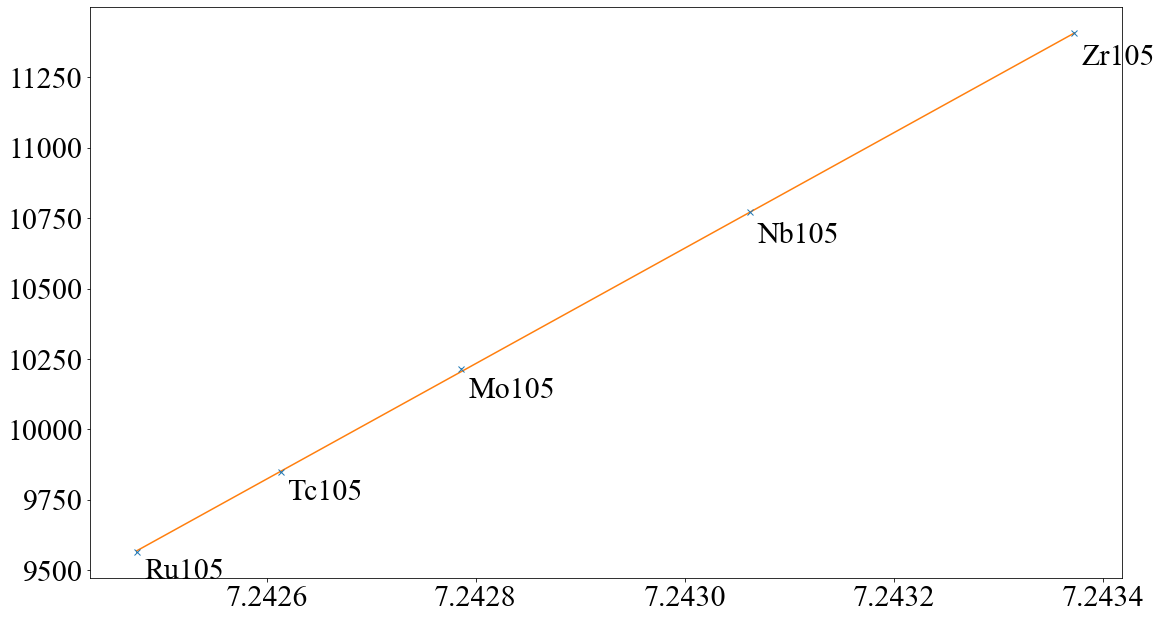

In [23]:
### Fail status -> change to python fit
import scipy.odr as scipyfit
# Define a function 
def quad_func(p, x):
     m, c = p
     return m*x**2 + c
def lin_func(p, x):
     m, c = p
     return m*x + c

# Create a model for fitting.
lin_model = scipyfit.Model(lin_func)

# Create a RealData object using our initiated data from above.
data = scipyfit.RealData(ROOT.x, ROOT.y, sx=ROOT.dx, sy=ROOT.dy)

# Set up ODR with the model and data.
odr = scipyfit.ODR(data, lin_model, beta0=[0., 1.])

# Run the regression.
out = odr.run()

# Use the in-built pprint method to give us results.
out.pprint()

x_fit = np.linspace(ROOT.x[0],ROOT.x[-1],1000)
y_fit = lin_func(out.beta, x_fit)

fig,axis = plt.subplots()
fig.set_size_inches(18.5,10.5)
fig.subplots_adjust(hspace=0,wspace=0)

axis.errorbar(ROOT.x, ROOT.y, xerr=ROOT.dx, yerr=ROOT.dy, linestyle='None', marker='x')
for idx,i in enumerate(ROOT.pname):
    axis.text(ROOT.x[idx]+ROOT.x[idx]*0.000001,ROOT.y[idx]-0.01*ROOT.y[idx],i,fontsize=30)
#     print(i,idx)
axis.plot(x_fit, y_fit)

print()
print(r"a+bl = %.10f \pm %.10f" % (out.beta[0],out.sd_beta[0]))
print(r"t_{0} = %.10f \pm %.10f" % (out.beta[1],out.sd_beta[1]))
# print(out.sd_beta[1]/out.beta[1])

Text(0.5, 0, 'TOF+$t_{0}$ (ns)')

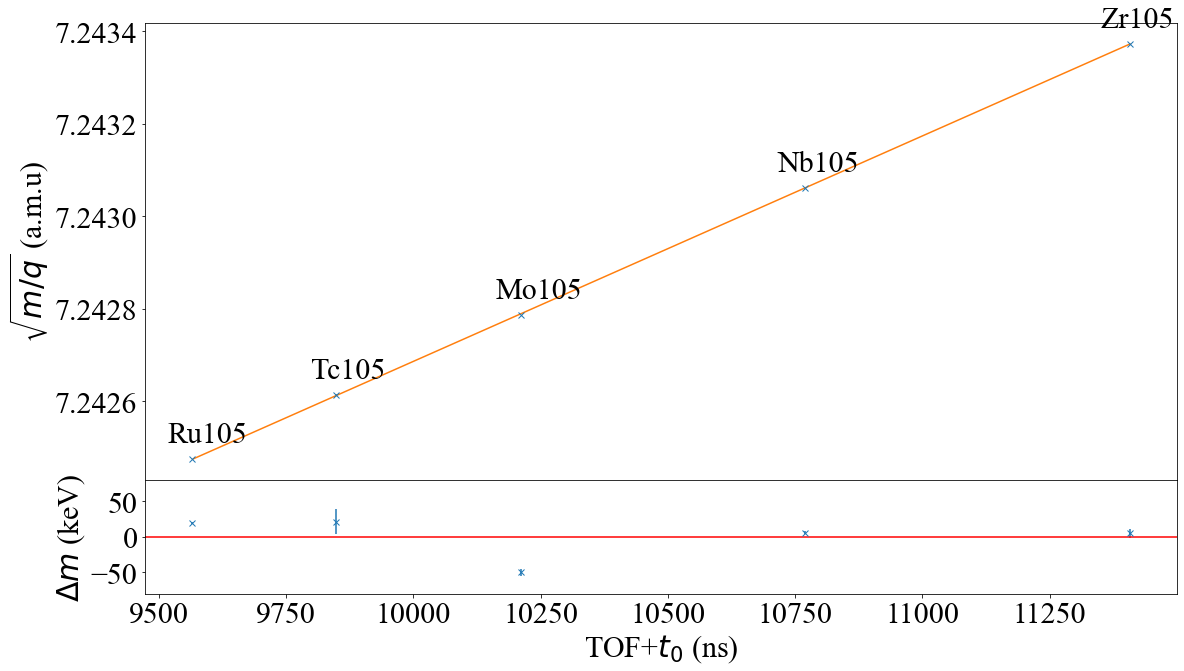

In [24]:
### residual plot
fig,axis = plt.subplots(2,1,sharex='col', gridspec_kw={'height_ratios': [4, 1]})
fig.set_size_inches(18.5,10.5)
fig.subplots_adjust(hspace=0,wspace=0)

axis[0].errorbar(ROOT.y, ROOT.x, xerr=ROOT.dy, yerr=ROOT.dx, linestyle='None', marker='x')
axis[0].plot(y_fit,x_fit)
axis[0].set_ylabel("$\sqrt{m/q}$ (a.m.u)")

for idx,i in enumerate(ROOT.pname):
    axis[0].text(ROOT.y[idx]-0.005*ROOT.y[idx],ROOT.x[idx]+ROOT.x[idx]*0.000005,i,fontsize=30)
    
xres = []
xres_err = []
for idx,i in enumerate(ROOT.y):
    xres.append(ROOT.x[idx]**2*u1-((i-out.beta[1])/out.beta[0])**2*u1)
    xres_err.append(2*ROOT.x[idx]*ROOT.dx[idx]*u1)
    
axis[1].errorbar(ROOT.y, xres, xerr=ROOT.dy, yerr=xres_err, linestyle='None', marker='x')
axis[1].axhline(0,color='r')
axis[1].set_ylim([-80,80])
axis[1].set_ylabel("$\Delta m$ (keV)")
axis[1].set_xlabel("TOF+$t_{0}$ (ns)")

Beta: [  2065215.85084432 -14799821.78991077]
Beta Std Error: [ 34510.69018979 247561.30438709]
Beta Covariance: [[ 2.64472790e+06 -1.89718689e+07]
 [-1.89718689e+07  1.36094079e+08]]
Residual Variance: 450.3252440920947
Inverse Condition #: 9.601015595830202e-06
Reason(s) for Halting:
  Sum of squares convergence

a+bl = 2065215.8508443204 \pm 34510.6901897854
t_{0} = -14799821.7899107691 \pm 247561.3043870901


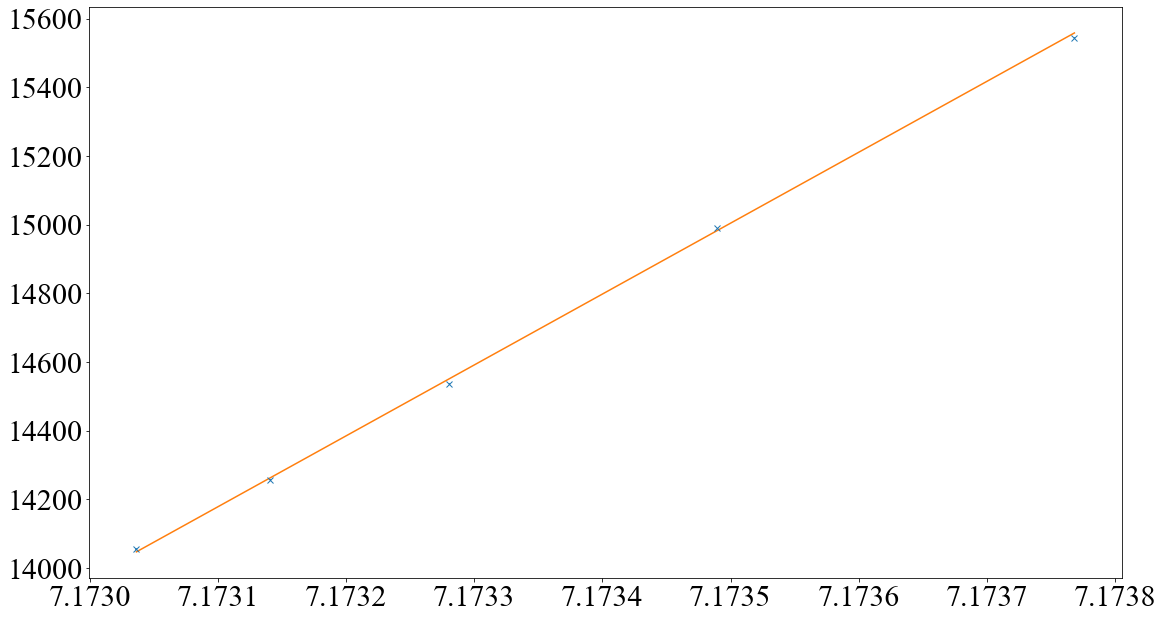

In [25]:
### Fail status -> change to python fit
import scipy.odr as scipyfit
# Define a function 
def quad_func(p, x):
     m, c = p
     return m*x**2 + c
def lin_func(p, x):
     m, c = p
     return m*x + c

# Create a model for fitting.
lin_model = scipyfit.Model(lin_func)

# Create a RealData object using our initiated data from above.
data = scipyfit.RealData(ROOT.x2, ROOT.y2, sx=ROOT.dx2, sy=ROOT.dy2)

# Set up ODR with the model and data.
odr = scipyfit.ODR(data, lin_model, beta0=[0., 1.])

# Run the regression.
out2 = odr.run()

# Use the in-built pprint method to give us results.
out2.pprint()

x_fit = np.linspace(ROOT.x2[0],ROOT.x2[-1],1000)
y_fit = lin_func(out2.beta, x_fit)

fig,axis = plt.subplots()
fig.set_size_inches(18.5,10.5)
fig.subplots_adjust(hspace=0,wspace=0)

axis.errorbar(ROOT.x2, ROOT.y2, xerr=ROOT.dx2, yerr=ROOT.dy2, linestyle='None', marker='x')
axis.plot(x_fit, y_fit)
print()
print(r"a+bl = %.10f \pm %.10f" % (out2.beta[0],out2.sd_beta[0]))
print(r"t_{0} = %.10f \pm %.10f" % (out2.beta[1],out2.sd_beta[1]))
# print(out.sd_beta[1]/out.beta[1])

Text(0.5, 0, 'TOF+$t_{0}$ (ns)')

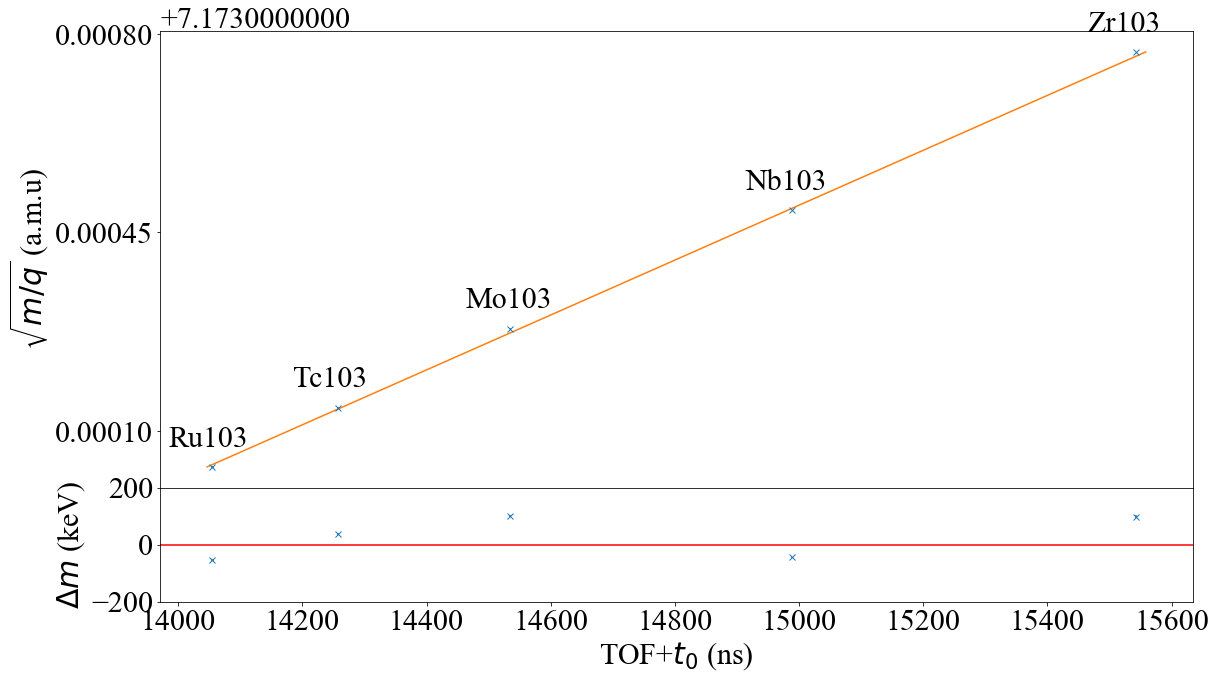

In [26]:
### residual plot
fig,axis = plt.subplots(2,1,sharex='col', gridspec_kw={'height_ratios': [4, 1]})
fig.set_size_inches(18.5,10.5)
fig.subplots_adjust(hspace=0,wspace=0)

axis[0].errorbar(ROOT.y2, ROOT.x2, xerr=ROOT.dy2, yerr=ROOT.dx2, linestyle='None', marker='x')
axis[0].plot(y_fit,x_fit)
axis[0].set_yticks(np.linspace(0.0001+7.173,0.0008+7.173,3))
axis[0].set_ylabel("$\sqrt{m/q}$ (a.m.u)")
for idx,i in enumerate(ROOT.pname2):
    axis[0].text(ROOT.y2[idx]-0.005*ROOT.y2[idx],ROOT.x2[idx]+ROOT.x2[idx]*0.000005,i,fontsize=30)

xres = []
xres_err = []
for idx,i in enumerate(ROOT.y2):
    xres.append(ROOT.x2[idx]**2*u1-((i-out2.beta[1])/out2.beta[0])**2*u1)
    xres_err.append(2*ROOT.x2[idx]*ROOT.dx2[idx]*u1)
axis[1].errorbar(ROOT.y2, xres, xerr=ROOT.dy2, yerr=xres_err, linestyle='None', marker='x')
axis[1].axhline(0,color='r')
axis[1].set_ylim([-200,200])
axis[1].set_ylabel("$\Delta m$ (keV)")
axis[1].set_xlabel("TOF+$t_{0}$ (ns)")

## $t_{0}$ and $(a+b\cdot l)$ determination:

$$
t_{obs} = (a+b\cdot l) (m/q)^{1/2} +t_{0}
$$

- 700 laps Mass 105
$$
t_{0} = -14837546.9910705741 \pm 54949.5772539974
$$
$$
a+b\cdot l = 2050005.5478560631 \pm 7586.6543886225
$$

- 707 laps Mass 103
$$
t_{0} = -14799651.6423837095 \pm 247689.4832553759
$$
$$
a+b\cdot l = 2065192.1318440652 \pm 34528.5594679795
$$

### Lets assume  a = 0, then the b  / per laps number would be:

In [27]:
out.beta[0]/700

2928.5875332343217

In [28]:
out2.beta[0]/707

2921.0973845039894

In [29]:
t0 = (out2.beta[1]+out.beta[1])/2
print(t0)

-14818705.124821845
